# FINM 33210 Final Project

This project will guide you through a typical buy-side quant research project, in which you will use some of the statistical learning methods discussed earlier in the course to analyze a multi-factor model of the type discussed in module 4. 

## Import Packages

In [450]:
import pandas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from statsmodels.formula.api import ols
from scipy.stats import gaussian_kde
import scipy
import scipy.sparse
import patsy
from statistics import median
import bz2
import math

## Load Data

In general, parsing text into numbers, dates, and other python data types can be done once, at the beginning of a research project, and the results can be saved to binary files. If the files are more than a few megabytes, use compression to avoid filling up your disk. In the following example, the model data has already been pre-processed and saved into pickle files, and the bz2 compression algorithm was used.

In [451]:
model_dir = '/Users/tb/Downloads/FinalProjectData/'

def sort_cols(test): 
    return(test.reindex(sorted(test.columns), axis=1))

frames = {}
for year in [2003,2004,2005,2006]:
    fil = model_dir + "pandas-frames." + str(year) + ".pickle.bz2"
    frames.update(pickle.load( bz2.open( fil, "rb" ) ))

for x in frames: 
    frames[x] = sort_cols(frames[x])
    
covariance = {}
for year in [2003,2004,2005,2006]:
    fil = model_dir + "covariance." + str(year) + ".pickle.bz2"
    covariance.update(pickle.load( bz2.open(fil, "rb" ) ))

## the following dates array is used later for constructing time series plots

my_dates = sorted(list(map(lambda date: pd.to_datetime(date, format='%Y%m%d'), frames.keys())))

## Data Definitions

After the above loading operation is finished, "frames" will be a dictionary keyed by date. For example, the string "20040102" is one such key. Accessing the value at this key, with frames["20040102"], gives a data frame containing a daily cross section. Each row in the data frame corresponds to a particular stock, and there are many columns containing various attributes of the stock that have been collected. The meanings of the columns that we will use in this project are defined below; columns which may exist in the data, but not listed here, are not needed.


- ID: a unique identifier that can be used to link stocks across time 
- DataDate: the date when the data would have been known, as of the close 


## Factors

- 1DREVRSL: very short-term reversal, potential alpha factor but probably too fast-moving to be tradable 
- STREVRSL: short-term reversal, potential alpha factor 
- LTREVRSL: long-term reversal, potential risk factor 
- BETA: risk factor computed from CAPM beta regression
- EARNQLTY: earnings quality, potential alpha factor 
- EARNYILD: earnings yield (blend of forecasted earnings and historical earnings divided by market cap) 
- GROWTH: mix of historical and forecasted earnings growth 
- INDMOM: industry momentum (relative historical performance of the other stocks in the same industry) 
- LEVERAGE: financial leverage of the company's balance sheet, usually a risk factor 
- LIQUIDTY: factor with high loadings for very liquidly traded names; usually a risk factor 
- MGMTQLTY: alpha factor which looks at quantitative measures of how well-run a company is by its management 
- MOMENTUM: 12-month growth in stock price, usually a risk factor 
- PROFIT: profitability, potential alpha factor 
- PROSPECT: based on skewness of the return distribution, potential risk factor 
- RESVOL: risk factor computed from residual volatility 
- SEASON: seasonality-based alpha factor 
- SENTMT: news sentiment alpha factor 
- SIZE: risk factor based on log(market capitalization) 
- VALUE: risk factor based on ratio of tangible book value to current price 


## Non-factor Attributes

- Ret: asset's total return on the next day after the factor loadings are known, suitable as the Y vector in a regression analysis 
- SpecRisk: specific risk is another name for predicted residual volatility. We called this the D matrix in our discussion of APT models. 
- TotalRisk: predicted total vol, including factor and idiosyncratic contributions, annualized 
- Yield: the dividend yield of the asset 
- HistBeta: historically estimated CAPM beta coefficient 
- PredBeta: model-predicted beta coefficient in the future 
- IssuerMarketCap: aggregate market capitalization of the company (all share classes from the same issuer)
- BidAskSpread: bid-offer spread (average for the day) 
- CompositeVolume: composite trading volume for the day 



## Industry factors


'AERODEF', 'AIRLINES', 'ALUMSTEL', 'APPAREL', 'AUTO',
       'BANKS','BEVTOB', 'BIOLIFE', 'BLDGPROD','CHEM', 'CNSTENG', 'CNSTMACH', 'CNSTMATL', 'COMMEQP', 'COMPELEC',
       'COMSVCS', 'CONGLOM', 'CONTAINR', 'DISTRIB',
       'DIVFIN', 'ELECEQP', 'ELECUTIL', 'FOODPROD', 'FOODRET', 'GASUTIL',
       'HLTHEQP', 'HLTHSVCS', 'HOMEBLDG', 'HOUSEDUR','INDMACH', 'INSURNCE', 'INTERNET', 
        'LEISPROD', 'LEISSVCS', 'LIFEINS', 'MEDIA', 'MGDHLTH','MULTUTIL',
       'OILGSCON', 'OILGSDRL', 'OILGSEQP', 'OILGSEXP', 'PAPER', 'PHARMA',
       'PRECMTLS','PSNLPROD','REALEST',
       'RESTAUR', 'ROADRAIL','SEMICOND', 'SEMIEQP','SOFTWARE', 'SPLTYRET', 'SPTYCHEM', 'SPTYSTOR',
       'TELECOM', 'TRADECO', 'TRANSPRT', 'WIRELESS'

## Data Cleaning and Winsorization

The distribution of many statistics can be heavily influenced by outliers. A simple approach to robustifying parameter estimation procedures is to set all outliers to a specified percentile of the data; for example, a 90% winsorization would see all data below the 5th percentile set to the 5th percentile, and data above the 95th percentile set to the 95th percentile. Winsorized estimators are usually more robust to outliers than their more standard forms.

In [452]:
def wins(x,a,b):
    return(np.where(x <= a,a, np.where(x >= b, b, x)))

def clean_nas(df): 
    numeric_columns = df.select_dtypes(include=[np.number]).columns.tolist()
    
    for numeric_column in numeric_columns: 
        df[numeric_column] = np.nan_to_num(df[numeric_column])
    
    return df

We can check the distribution of returns with a density plot, both before and after winsorization to observe the effect of trimming the tails.

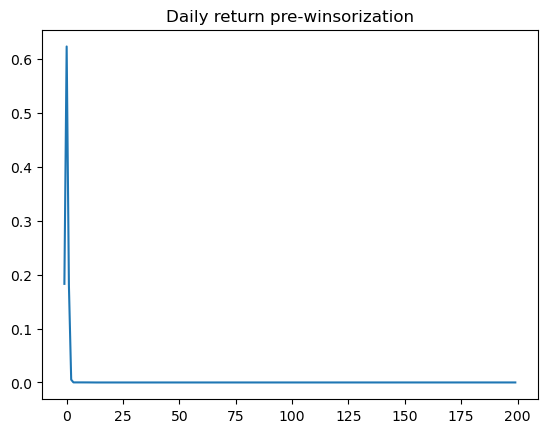

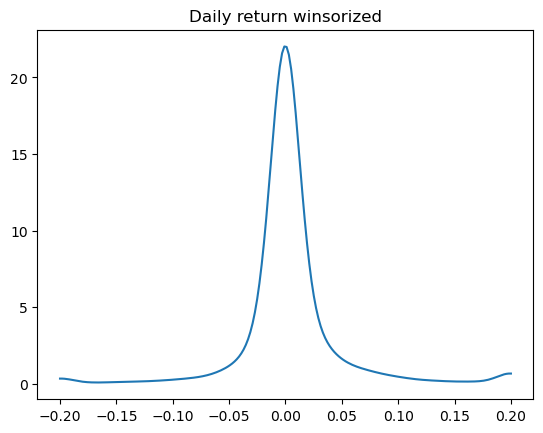

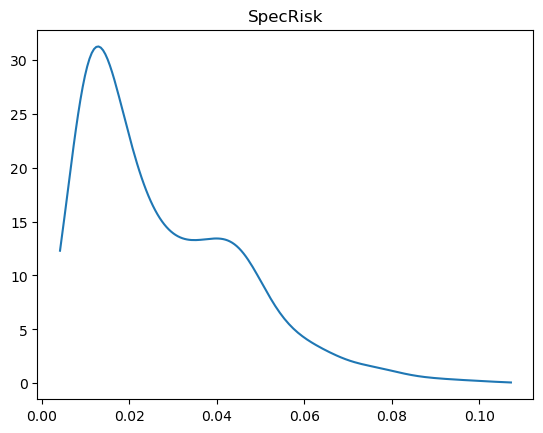

In [453]:
def density_plot(data, title): 
    density = gaussian_kde(data)
    xs = np.linspace(np.min(data),np.max(data),200)
    density.covariance_factor = lambda : .25
    density._compute_covariance()
    plt.plot(xs,density(xs))
    plt.title(title)
    plt.show()
    
test = frames['20040102']
density_plot(test['Ret'], 'Daily return pre-winsorization')
density_plot(wins(test['Ret'],-0.2,0.2), 'Daily return winsorized')

D = (test['SpecRisk'] / (100 * math.sqrt(252))) ** 2
density_plot(np.sqrt(D), 'SpecRisk')

# Factors

## Factor Exposures and Factor Returns


Arbitrage pricing theory relaxes several of the assumptions made in the course of deriving 
the CAPM. In particular, we relax the assumption that all investors do the same optimization 
and hence that there is a single efficient fund. This allows the possibility that a CAPM-like 
relation may hold, but with multiple underlying sources of risk. 

Specifically, let $r_i, i = 1, \ldots, n$ denote the cross-section of asset returns over a given 
time period $[t, t+1]$. In a fully-general model, the multivariate distribution $p(\mathbf{r})$ could have 
arbitrary covariance and higher-moment structures, but remember that for $n$ large there is 
typically never enough data to estimate such over-parameterized models. 

Instead, we assume a
structural model which is the most direct generalization of the CAPM: 
$$
	r_i = \beta_{i, 1} f_1 + \beta_{i,2} f_2 + \dots + \beta_{i, p} f_p + \epsilon_i, \quad 
	\epsilon_i \sim N(0, \sigma_i^2)  
$$
If $p = 1$, this reduces to the Capital Asset Pricing Model (CAPM) in a rather direct way. 

With $p > 1$, the model starts to differ from the CAPM 
in several very important aspects. In the CAPM, we were 
able to identify the single efficient fund by arguing that its weights must equal the 
market-capitalization weights. Hence we were given for free a very nice proxy for the 
single efficient fund: a capitalization-weighted basket such as the Russell 3000. 
Hence in the $p=1$ case we had a convenient proxy which could be used to impute 
the return $f_1$, which we called $r_M$. Also $\beta_{i, 1}$ could be estimated, with 
no more than the usual statistical estimation error, by time-series regression. 

If $p > 1$ then the underlying assumptions of that argument break down: there is no
longer any simple way to identify $f_{j}$ nor $\beta_{i, j}$ ($j = 1, \ldots, p$). 
We shall return to the estimation problem in due course. 


To avoid confusion with the CAPM, and its simplistic $\beta$ coefficient (which is still 
sometimes used in larger multi-factor models), it is conventional to make the following 
notation change: $\beta_{i,j}$ becomes $X_{i,j}$ and so the model equation becomes 
$$
	 	r_i = X_{i, 1} f_1 + X_{i,2} f_2 + \dots + X_{i, p} f_p + \epsilon_i, \quad 
	\epsilon_i \sim N(0, \sigma_i^2)  
$$
It's difficult to simultaneously estimate both all components $X_{i,j}$ and all risk-source 
returns $f_j$, so one usually assumes one is known and calculates the other via regression. 
In what follows, we focus on the approach where $X$ is known, and the $f_j$ are assumed
to be hidden (aka latent) variables.

The structural equation is more conveniently expressed in matrix form: 
$$
	R_{t+1} = X_t f_{t+1} + \epsilon_{t+1}, \quad E[\epsilon] = 0, \ \ V[\epsilon] = D 
$$
where $R_{t+1}$ is an $n$-dimensional random vector containing the 
cross-section of returns in excess of the risk-free rate over some 
time interval $[t, t+1]$, and $X_t$ is a (non-random) $n \times p$ matrix 
that can be calculated entirely from data known before time $t$.
The variable $f$ in denotes a $p$-dimensional random vector
process which cannot be observed directly. 

Since the variable $f$ denotes a $p$-dimensional random vector process which cannot 
be observed directly, information about the $f$-process must be obtained via statistical inference. 
We assume that the $f$-process has finite first and second moments given by 
$$
	E[f] = \mu_f, \ \text{ and } \  V[f] = F . 
$$ 
The primary outputs of a statistical inference process are the parameters 
$\mu_f$ and $F$, and other outputs one might be interested in
include estimates of the daily realizations $\hat{f}_{t+1}$. 

The simplest way of estimating historical daily realizations of $\hat{f}_{t+1}$ is by least-squares (ordinary or weighted, as appropriate), viewing the defining 
model equation as a regression problem. 

In [454]:
industry_factors = ['AERODEF', 'AIRLINES', 'ALUMSTEL', 'APPAREL', 'AUTO',
       'BANKS','BEVTOB', 'BIOLIFE', 'BLDGPROD','CHEM', 'CNSTENG', 'CNSTMACH', 'CNSTMATL', 'COMMEQP', 'COMPELEC',
       'COMSVCS', 'CONGLOM', 'CONTAINR', 'DISTRIB',
       'DIVFIN', 'ELECEQP', 'ELECUTIL', 'FOODPROD', 'FOODRET', 'GASUTIL',
       'HLTHEQP', 'HLTHSVCS', 'HOMEBLDG', 'HOUSEDUR','INDMACH', 'INSURNCE', 'INTERNET', 
        'LEISPROD', 'LEISSVCS', 'LIFEINS', 'MEDIA', 'MGDHLTH','MULTUTIL',
       'OILGSCON', 'OILGSDRL', 'OILGSEQP', 'OILGSEXP', 'PAPER', 'PHARMA',
       'PRECMTLS','PSNLPROD','REALEST',
       'RESTAUR', 'ROADRAIL','SEMICOND', 'SEMIEQP','SOFTWARE', 'SPLTYRET', 'SPTYCHEM', 'SPTYSTOR',
       'TELECOM', 'TRADECO', 'TRANSPRT', 'WIRELESS']

style_factors = ['BETA', 'SIZE', 'MOMENTUM', 'VALUE', 'GROWTH', 'LEVERAGE', 'LIQUIDTY', 
                 'DIVYILD', 'LTREVRSL', 'EARNQLTY']

## an R-style formula which can be used to construct a cross sectional regression
def get_formula(alphas, Y):
    L = ["0"]
    L.extend(alphas)
    L.extend(style_factors)
    L.extend(industry_factors)
    return Y + " ~ " + " + ".join(L)

## The term 'estu' is short for estimation universe
def get_estu(df): 
    estu = df.loc[df.IssuerMarketCap > 1e9].copy(deep=True)
    return estu

def estimate_factor_returns(df, alphas): 
    ## build universe based on filters 
    estu = get_estu(df)
    
    ## winsorize returns for fitting 
    estu['Ret'] = wins(estu['Ret'], -0.25, 0.25)
    
    model = ols(get_formula(alphas, "Ret"), data=estu)
    return(model.fit())

## Alpha factor selection

In a real trading scenario, alpha factor construction would be the culmination of a very long research process, usually undertaken by experts in financial markets and requiring time and ingenuity. 
For this exercise, we consider several well-known alpha factors from the list above. 

Running one OLS per day over several years, where each OLS involves several thousand observations and about 50-100 independent variables, takes a few minutes.

In [455]:
alpha_factors = ['STREVRSL', 'MGMTQLTY', 'SENTMT', 'EARNYILD', 'SEASON', 'INDMOM']

In [456]:
facret = {}

for date in frames:
    facret[date] = estimate_factor_returns(frames[date], list(alpha_factors)).params

We now have a multivariate time series of factor returns stored in the variable facret. We can plot the cumulative sum of the factor returns. 

<AxesSubplot:>

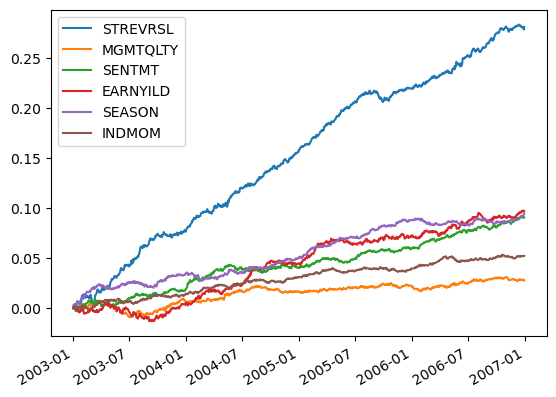

In [457]:
facret_df = pd.DataFrame(index = my_dates)

for dt in my_dates: 
    for alp in alpha_factors: 
        facret_df.at[dt, alp] = facret[dt.strftime('%Y%m%d')][alp]

facret_df.cumsum().plot()

The following table gives the vector called $\mu_f$ in lecture.

In [458]:
print(facret_df.mean())

STREVRSL    0.000279
MGMTQLTY    0.000027
SENTMT      0.000090
EARNYILD    0.000096
SEASON      0.000094
INDMOM      0.000052
dtype: float64


## Helpful code to show how to get X, F, D matrices for a particular date

In [459]:
def colnames(X):
    if(type(X) == patsy.design_info.DesignMatrix): 
        return(X.design_info.column_names)
    if(type(X) == pandas.core.frame.DataFrame): 
        return(X.columns.tolist())
    return(None)

def diagonal_factor_cov(date, X):
    cv = covariance[date]
    k = np.shape(X)[1]
    Fm = np.zeros([k,k])
    for j in range(0,k): 
        fac = colnames(X)[j]
        Fm[j,j] = (0.01**2) * cv.loc[(cv.Factor1==fac) & (cv.Factor2==fac),"VarCovar"].iloc[0]
    return(Fm)

def risk_exposures(estu): 
    L = ["0"]
    L.extend(style_factors)
    L.extend(industry_factors)
    my_formula = " + ".join(L)
    return patsy.dmatrix(my_formula, data = estu)

In [460]:
my_date = '20040102'

# estu = estimation universe
estu = get_estu(frames[my_date])
n = estu.shape[0]

estu['Ret'] = wins(estu['Ret'], -0.25, 0.25)

rske = risk_exposures(estu)
F = diagonal_factor_cov(my_date, rske)

X = np.asarray(rske)
D = np.asarray( (estu['SpecRisk'] / (100 * math.sqrt(252))) ** 2 )

kappa = 1e-5

print(F)

[[0.00348478 0.         0.         ... 0.         0.         0.        ]
 [0.         0.00061952 0.         ... 0.         0.         0.        ]
 [0.         0.         0.00042807 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.00521378 0.         0.        ]
 [0.         0.         0.         ... 0.         0.00726435 0.        ]
 [0.         0.         0.         ... 0.         0.         0.02185539]]


### Problem 1. 

Consider the list of potential alpha factors whose factor returns were plotted above. Consider ways of combining all of the alpha factors into a single, composite alpha factor. The goal is to produce a composite alpha factor which does the best job of predicting the dependent variable "Ret" on out-of-sample data. Restrict your training set on each day to the estimation universe that was used above in get_estu. Take the period 2008-2010 as the ultimate test set which you will hold in a "vault" until you are ready to do a final evaluation of your composite alpha factor. Use the period 2003-2007 for training/validation. Use cross-validation to select a model from the full family of models you are considering. It could be as simple as lasso, but we encourage you to be creative and try non-linear combinations of factors as well. Use methods from the course. 


### Problem 2. 

Referring to formula (4.3) for the Markowitz portfolio, and the covariance matrix in (4.29), code up a function to compute the Markowitz portfolio for each date in our sample. Refer to the helpful code above to get the different pieces in (4.29). For the risk-aversion constant, use $\kappa$ = 1e-5. Restrict yourself to the estimation universe that was used above in get_estu. Use your composite alpha factor from Problem 1 as the substitute for $ \mathbb{E}[\mathbf{r}]$. It is recommended to use the fast inversion formula (4.32) to speed things up. Compute the dot product of your portfolio with the return, that is compute $\mathbf{h} \cdot \mathbf{r}$ for each date in the sample, and plot the cumulative sum of the results. For $\mathbf{r}$, use the column called "Ret" in the same data frame that was used to compute the portfolio itself. 

### Extra credit

Plot other interesting metrics which help understand the portfolios in problem 2. For example, plot their long/short/net in dollars, number of holdings, factor model's predicted volatility of the portfolio, percent of variance from idio, style, industry. 

### Teamwork

Note that problem 2 only needs the output from Problem 1, but it does not depend on the details of how Problem 1 is being solved. So a team could split up along those lines. Part of the team can start on Problem 2, just assuming the output from problem 1 is, say, a single one of the alpha factors, until the part of the team doing problem 1 has something more interesting. 

# Problem 1

In [461]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn import linear_model

In [462]:
facret_df = pd.DataFrame(index = my_dates)

for dt in my_dates: 
    for alp in alpha_factors: 
        facret_df.at[dt, alp] = facret[dt.strftime('%Y%m%d')][alp]

In [463]:
PC = []
SVD = []
composite_factors = []
pred_ret = []

for d_str, d_td in zip(frames.keys(), list(facret_df.index)):
    estu = get_estu(frames[d_str])
    x = (estu.loc[:, alpha_factors] * facret_df.loc[d_td ,]).values
    y = estu.Ret.values
    x = StandardScaler().fit_transform(x)
    # pca = PCA(n_components = 1) #'n_components = 'mle' , svd_solver='full
    # principalComponent = pca.fit_transform(x,y)

    svd = TruncatedSVD(n_components=1, n_iter=10, random_state=0)
    svd_Component = svd.fit_transform(x,y)

    reg = linear_model.LinearRegression()
    composite_factor = reg.fit(svd_Component, y).coef_[0]
    pred = reg.predict(svd_Component)

    # PC.append( principalComponent)
    SVD.append(svd_Component)
    composite_factors.append(composite_factor)
    pred_ret.append(pred.mean())


In [464]:
med_ret = []
for k in frames.keys():
    estu = get_estu(frames[k])
    med_ret.append(estu.Ret.mean())

facret_df['med_Ret'] = med_ret
facret_df['Comb_factor'] = composite_factors
facret_df['SVD_pred_ret'] = pred_ret

# PCA

# x = facret_df.loc[:, alpha_factors].values
# y = facret_df.loc[:,['med_Ret']].values
# x = StandardScaler().fit_transform(x)

# pca = PCA(n_components = 1) #'n_components = 'mle' , svd_solver='full
# principalComponents = pca.fit_transform(x,y)

# facret_df['PCA'] = principalComponents 
# # facret_df['PCA_ret']  = facret_df['med_Ret'] *  facret_df['PCA']
# facret_df['PCA_ret'] =  facret_df['med_Ret'].values.reshape(-1, 1).dot(principalComponents .T )
# # facret_df['PCA_ret'] =  facret_df[alpha_factors].dot(pca.components_.T )

facret_df

,STREVRSL,MGMTQLTY,SENTMT,EARNYILD,SEASON,INDMOM,med_Ret,Comb_factor,SVD_pred_ret
2003-01-02,0.000045,0.001079,-0.000035,0.000350,-0.000393,-0.000593,0.015775,0.000432,0.015775
2003-01-03,0.002849,-0.000646,0.001068,0.000178,0.001919,0.000100,-0.007137,0.002620,-0.007137
2003-01-06,0.000178,0.001266,0.000342,0.002455,0.002143,0.001341,-0.011691,-0.001737,-0.011691
2003-01-07,0.000481,-0.000505,-0.000716,0.001071,-0.000654,-0.000190,0.015275,0.002137,0.015275
2003-01-08,-0.000377,-0.000042,-0.001806,-0.001368,-0.000341,0.001020,0.002394,0.002658,0.002394
...,...,...,...,...,...,...,...,...,...
2006-12-22,-0.000059,-0.000234,-0.000411,0.000950,0.000140,0.000099,0.008414,-0.000349,0.008414
2006-12-26,-0.000097,0.000028,0.000165,0.000365,0.000571,0.000193,-0.000772,-0.000747,-0.000772
2006-12-27,-0.000623,0.000325,-0.000387,-0.000926,0.000653,0.000083,-0.003025,-0.001021,-0.003025
2006-12-28,-0.001413,-0.000199,-0.000114,0.000246,0.001355,0.000070,0.000867,-0.000155,0.000867


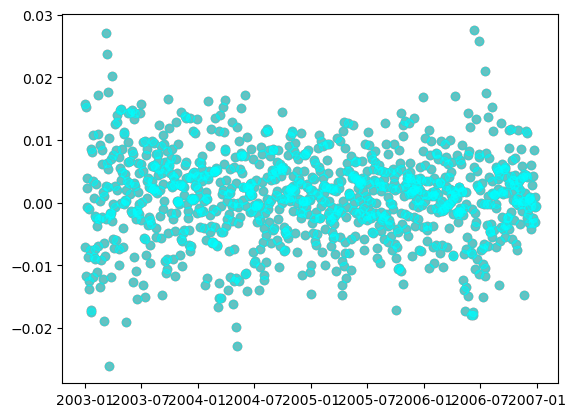

In [465]:
plt.scatter(x= facret_df.index.values, y= facret_df['SVD_pred_ret'] , alpha=0.6, c = 'red')
plt.scatter(x= facret_df.index.values, y= facret_df['med_Ret'] , alpha=0.6, c='cyan')

<AxesSubplot:>

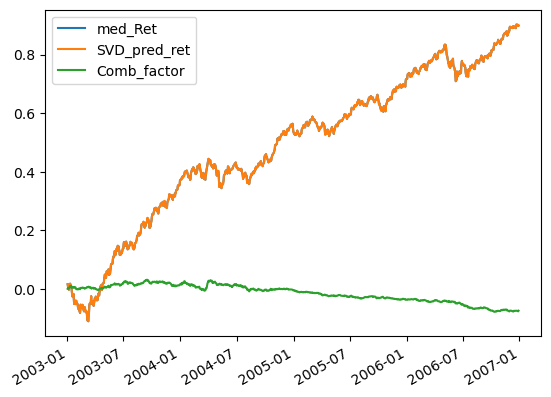

In [466]:
facret_df[['med_Ret','SVD_pred_ret',"Comb_factor"]].cumsum().plot()

In [467]:
# pca = PCA(n_components = 'mle')
# principalComponents = pca.fit_transform(x)

# # facret_df['PCA'] = principalComponents 
# facret_df['PCA_ret'] =  facret_df[alpha_factors].dot(pca.components_.T )
# # principalDf = pd.DataFrame(data = principalComponents
# #              , columns = ['principal component 1', 'principal component 2'])
# facret_df

# 2

In [469]:

my_date = '20040615'

# estu = estimation universe
estu = get_estu(frames[my_date])
n = estu.shape[0]

estu['Ret'] = wins(estu['Ret'], -0.25, 0.25)

rske = risk_exposures(estu)
F = diagonal_factor_cov(my_date, rske)

X = np.asarray(rske)
D = np.asarray( (estu['SpecRisk'] / (100 * math.sqrt(252))) ** 2 )

kappa = 1e-5

In [476]:
np.linalg.det((D + X @ F @ X.T))

-0.0

In [480]:
kappa * np.linalg.inv((D + X @ F @ X.T))

array([[ 6.27671646e+13, -8.22009801e+13,  4.02625634e+14, ...,
        -4.35395406e+13,  2.94893969e+13, -2.34084487e+14],
       [ 1.45957735e+14, -4.55412627e+13,  3.26728860e+14, ...,
        -8.70430132e+13,  2.24284583e+13, -4.55358982e+13],
       [ 3.84227621e+13,  4.39934368e+13, -1.39910879e+14, ...,
        -3.62119445e+13, -2.71543799e+12, -8.89994253e+13],
       ...,
       [ 6.56140994e+12, -6.10803016e+12,  2.53047469e+13, ...,
        -6.61166862e+12,  1.72534831e+12, -2.38458194e+13],
       [-9.44551903e+12,  8.83967170e+12, -3.68085166e+13, ...,
         9.66759880e+12, -2.35344484e+12,  3.44138179e+13],
       [ 3.22315200e+12, -3.01711240e+12,  1.23352640e+13, ...,
        -3.26745287e+12,  1.08260403e+12, -1.20913809e+13]])

In [ ]:
frames_test = {}
for year in [2008,2009,2010]:
    fil = model_dir + "pandas-frames." + str(year) + ".pickle.bz2"
    frames_test.update(pickle.load( bz2.open( fil, "rb" ) ))

for x in frames_test: 
    frames_test[x] = sort_cols(frames_test[x])


In [481]:
# Calculate h* from the training set
H = []

for my_date, i in zip(frames.keys(),range(len(frames.keys()))):
    # estu = estimation universe
    
    estu = get_estu(frames[my_date])
    n = estu.shape[0]

    estu['Ret'] = wins(estu['Ret'], -0.25, 0.25)

    rske = risk_exposures(estu)
    F = diagonal_factor_cov(my_date, rske)

    X = np.asarray(rske)
    D = np.asarray( (estu['SpecRisk'] / (100 * math.sqrt(252))) ** 2 )

    k_sigma_inv = kappa * np.linalg.inv(D + X @ F @ X.T) # 2265 x 2265

    h_star = k_sigma_inv @ SVD[i] # 2265 x 2265 @ 2265 x 1
    H.append(h_star)
    

In [ ]:
len(SVD[4])

2299

In [ ]:
len(H)

112

In [ ]:
estu

,1DREVRSL,AERODEF,AIRLINES,ALUMSTEL,APPAREL,AUTO,BANKS,BETA,BEVTOB,BIOLIFE,...,SPTYSTOR,STREVRSL,SpecRisk,TELECOM,TRADECO,TRANSPRT,TotalRisk,VALUE,WIRELESS,Yield
0,-0.032,0.0,0.0,0.0,0.0,0.0,0.00,-2.177,0.0,0.0,...,0.0,0.548,9.014505,0.054,0.0,0.0,13.959397,0.644,0.0,0.188679
1,0.684,0.0,0.0,0.0,0.0,0.0,0.00,-2.045,0.0,0.0,...,0.0,0.986,19.304651,0.000,0.0,0.0,23.393503,-0.700,0.0,3.203463
3,0.759,0.0,0.0,0.0,0.0,0.0,0.00,-0.948,0.0,0.0,...,0.0,1.841,31.274403,0.000,0.0,0.0,35.785120,0.609,0.0,NaN
6,-0.059,0.0,0.0,0.0,0.0,0.0,0.00,-2.176,0.0,0.0,...,0.0,0.585,11.726327,0.000,0.0,0.0,17.033359,-0.646,0.0,0.000000
8,-2.583,0.0,0.0,0.0,0.0,0.0,0.00,-0.456,0.0,0.0,...,0.0,-0.479,22.126417,0.000,0.0,0.0,26.702272,-0.190,0.0,3.159453
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12430,-0.953,0.0,0.0,0.0,0.0,0.0,0.97,-2.009,0.0,0.0,...,0.0,0.430,9.095567,0.000,0.0,0.0,13.125982,0.928,0.0,2.770352
12431,-0.808,0.0,0.0,0.0,0.0,0.0,0.97,-2.066,0.0,0.0,...,0.0,0.561,8.739695,0.000,0.0,0.0,12.888183,0.966,0.0,7.175297
12432,-0.754,0.0,0.0,0.0,0.0,0.0,0.97,-2.053,0.0,0.0,...,0.0,0.734,9.565838,0.000,0.0,0.0,13.436052,0.818,0.0,2.770352
12433,-0.647,0.0,0.0,0.0,0.0,0.0,0.97,-2.022,0.0,0.0,...,0.0,0.680,9.394557,0.000,0.0,0.0,13.256003,0.774,0.0,2.770352


In [ ]:
k_sigma_inv = np.linalg.inv(kappa *(D + X @ F @ X.T))

In [ ]:
k_sigma_inv.shape

(2265, 2265)

In [ ]:
sigma_inv = np.linalg.inv(D) - np.linalg.inv(D) @ X @ np.linalg.inv(np.linalg.inv(F) + X.T @ np.linalg.inv(D) @ X) @ X.T @ np.linalg.inv(D)

LinAlgError: 1-dimensional array given. Array must be at least two-dimensional